## Optimization Problem with Entropic Value-at-Risk

The problem deals with Entropic Value at Risk which is a new risk measure introduced by Ahmad Jahvi(2011).
$$EVaR_{\alpha}(Y) = \inf_{t>0} \Big\{\frac{1}{t} \log \frac{1}{1-\alpha} m_Y (t)\Big\}$$
where $m_Y (t) = E [e^{tY}]$ is the moment generating function and $\alpha \in [0,1]$.

The problem is to $\min_x \{\ EVaR(-x^\top \xi)\}$ subject to $sum(x) = 1$ and $x,t > 0$

The problem can be transformed as follows;
$$\min_x\ \{EVaR_{\alpha}(-x^\top \xi)\} = \min_{x,t} \Big\{\frac{1}{t} \log \frac{1}{1-\alpha} E e^{-t x^\top \xi}\Big\}$$
which can also be written as
$$\min_{x,t}\Big\{  \frac{1}{t} \log \frac{1}{1-\alpha} \sum^J_{i=1} P_i \cdot e^{(-t \Xi x)_i}\Big\}$$
where J is the number of stocks in the portfolio.

#### Convexification of the objective function
The above objective function should be jointly convex in $(Y,t)$ as follows;
$$\min_{x,t} \Big\{  t \log \frac{1}{1-\alpha} \sum^J_{i=1} P_i \cdot e^{(-\frac{1}{t} \Xi x)_i}\Big\}$$

Since the problem is a non linear optimization problem, it is best to use the package scipy.optimize which has a function minimize for non linear optimization problems.

The formulation of the problem also involves using an historical financial data for four stocks(Walter Disney Co(DIS), Alibaba foundation(BABA),Johnson & Johnson(JNJ) and Facebook(FB)) for a tradin period of 8 years from January 1st, 2010 to January 1st, 2018.

In [1]:
#Importing packages required for the implementation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%pylab inline 
import pandas as pd
from scipy.optimize import minimize
import math as m
import numpy.linalg as nl
import seaborn as sns
pd.core.common.is_list_like = pd.api.types.is_list_like
from datetime import datetime
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Defining the start and end of our trading period.
import datetime
start_sp = datetime.datetime(2014, 1, 1)
end_sp = datetime.datetime(2018,1,1)
# Defining the reader to obtain the historical data.
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
# Getting the stocks from Yahoo.
dis = pdr.get_data_yahoo('DIS', start_sp,end_sp)
baba = pdr.get_data_yahoo('BABA', start_sp,end_sp)
jnj = pdr.get_data_yahoo('JNJ', start_sp,end_sp)
fb = pdr.get_data_yahoo('FB', start_sp,end_sp)
bond = pdr.get_data_yahoo('BOND', start_sp,end_sp)
# Getting the Adjusted closing prices for all the stocks.
dis_close = dis['Adj Close']
baba_close = baba['Adj Close']
jnj_close = jnj['Adj Close']
fb_close = fb['Adj Close']
bond_close = bond['Adj Close']
#Combining the data into one dataframe
combined_data_1 = dis_close.to_frame().merge(baba_close.to_frame(),
                                             left_on='Date', right_index=True)
combined_data_2 = combined_data_1.merge(jnj_close.to_frame(),
                                        left_on='Date', right_index=True)
dfw = combined_data_2.merge(fb_close.to_frame(),
                           left_on='Date', right_index=True)
dffree = dfw.merge(bond_close.to_frame(),
                 left_on='Date',right_index =True)
#dfw is the dataframe without the riskfree asset and dffree has a risk free asset
#Renaming the columns of our new dataframe
dfw.columns = ['dis','baba','jnj','fb']
dffree.columns = ['dis','baba','jnj','fb','bond']

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Note that dfw is a subset of dffree

In [3]:
print(dfw.describe())
print(dffree.describe())

              dis        baba         jnj          fb
count  827.000000  827.000000  827.000000  827.000000
mean    99.081474  102.502829  106.108039  116.907449
std      7.916591   33.012790   15.227761   31.759077
min     76.736649   57.389999   83.117859   72.629997
25%     93.682949   80.570000   91.951038   87.995002
50%     99.572166   90.570000  105.498016  114.610001
75%    105.078487  109.004998  117.391666  137.569999
max    116.366173  191.190002  139.116653  183.029999
              dis        baba         jnj          fb        bond
count  827.000000  827.000000  827.000000  827.000000  827.000000
mean    99.081474  102.502829  106.108039  116.907449   98.087996
std      7.916591   33.012790   15.227761   31.759077    2.761588
min     76.736649   57.389999   83.117859   72.629997   92.704308
25%     93.682949   80.570000   91.951038   87.995002   95.789253
50%     99.572166   90.570000  105.498016  114.610001   97.618347
75%    105.078487  109.004998  117.391666  137.56999

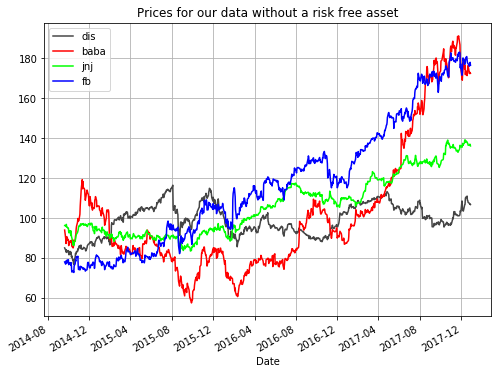

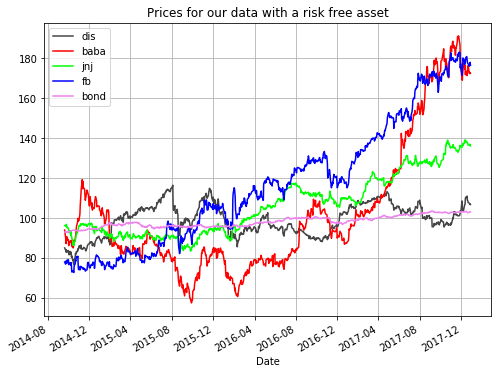

In [4]:
# Plof for the developments of the data
colors = ["#454545","#FF0000","#00FF00","#0000FF"]
colorss = ["#454545","#FF0000","#00FF00","#0000FF","violet"]
dfw.plot(figsize = (8,6),color = colors,grid = True)
plt.title("Prices for our data without a risk free asset")
plt.savefig("developments_without_riskfree.png")
plt.legend(loc = 2);
dffree.plot(figsize = (8,6),color = colorss,grid = True)
plt.title("Prices for our data with a risk free asset")
plt.savefig("developments_with_riskfree.png")
plt.legend(loc = 2);

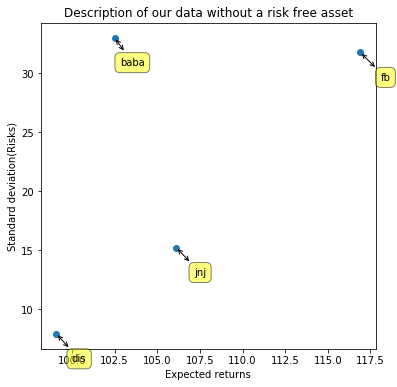

In [5]:
plt.scatter(dfw.mean(),dfw.std())
plt.xlabel("Expected returns")
plt.ylabel("Standard deviation(Risks)")
plt.title("Description of our data without a risk free asset")
for label,x,y,in zip(dfw.columns,dfw.mean(),dfw.std()):
    plt.annotate(label,xy=(x,y),xytext = (30,-30),
                textcoords = 'offset points',ha = 'right',va = 'bottom',
                bbox=dict(boxstyle = 'round,pad = 0.5',fc = 'yellow',alpha = 0.5),
                arrowprops = dict(arrowstyle = '<->',connectionstyle = 'arc3,rad = 0'))
plt.gcf().set_size_inches(6,6)

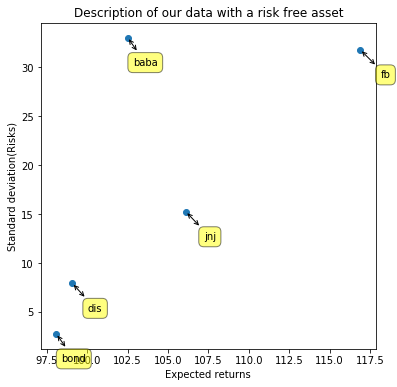

In [6]:
plt.scatter(dffree.mean(),dffree.std())
plt.xlabel("Expected returns")
plt.ylabel("Standard deviation(Risks)")
plt.title("Description of our data with a risk free asset")
for label,x,y,in zip(dffree.columns,dffree.mean(),dffree.std()):
    plt.annotate(label,xy=(x,y),xytext = (30,-30),
                textcoords = 'offset points',ha = 'right',va = 'bottom',
                bbox=dict(boxstyle = 'round,pad = 0.5',fc = 'yellow',alpha = 0.5),
                arrowprops = dict(arrowstyle = '<->',connectionstyle = 'arc3,rad = 0'))
plt.gcf().set_size_inches(6,6)

### Calculating the daily returns for both of the data

In [7]:
df_return = dfw.pct_change(1) #daily returns without only risky assets
df_return1 = dffree.pct_change(1) #daily returns with the risk less asset
df = df_return.drop(df_return.index[0])*365 #Dropping the NA's and normalizing for only risky assets
df1 = df_return1.drop(df_return1.index[0])*365 # with risk less asset

In [8]:
print(df1.head())

                 dis       baba       jnj        fb      bond
Date                                                         
2014-09-22 -4.840351 -15.550112 -0.371794 -5.200235  0.637511
2014-09-23 -4.006049 -11.044614 -1.420973  7.081370  0.301384
2014-09-24  4.711815  14.236558  4.008010  1.165538 -0.970500
2014-09-25 -5.631055  -6.649561 -5.173988 -6.134454  0.469680
2014-09-26  2.776773   6.321417  0.000000  7.421005 -1.172780


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd58643c2e8>,
      dtype=object)

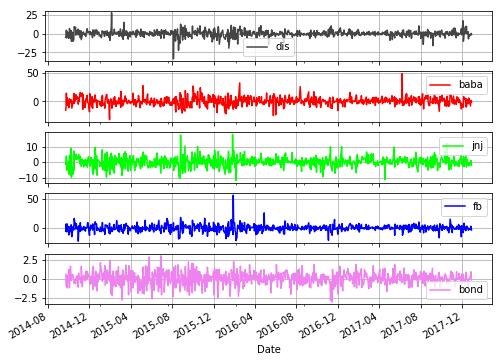

In [9]:
# Plof for the daily returns for our data
df1.plot(subplots=True,color = colorss,figsize = (8,6),grid = True)

In [10]:
print(df.shape)
print(df1.shape)

(826, 4)
(826, 5)


In the following, we want to fix the value of x and vary the values of t and plot the results to see the behaviour of the objective function if we are having a concave or a convex function for the fixed values of x and varied values of t

Text(0,0.5,'function value')

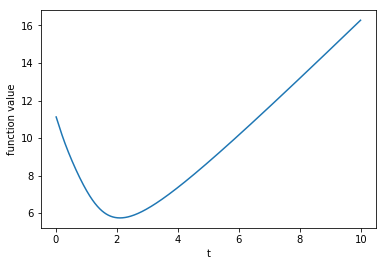

In [11]:
x0 = np.matrix([0.2,0.2,0.2,0.2])
alpha = 0.8
psi = df
prob=np.matrix(np.repeat((1/826),826))
t= np.arange(0.01,10,0.01)
fun = []
for tt in t:
    fun.append(tt*
           np.log((1.0/(1.0-alpha))*
                    np.sum(np.matmul(prob,
                                     np.exp((-1.0/tt)*
                                            np.matmul(psi,np.transpose(x0)))))))
plt.plot(t,fun)
plt.xlabel('t')
plt.ylabel('function value')

Text(0,0.5,'function value')

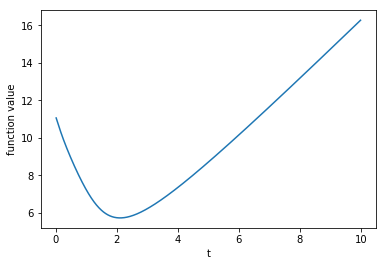

In [12]:
x0free = np.matrix([0.2,0.2,0.2,0.2,0.2])
alpha = 0.8
psi = df1
prob=np.matrix(np.repeat((1/826),826))
t= np.arange(0.01,10,0.01)
fun = []
for tt in t:
    fun.append(tt*
           np.log((1.0/(1.0-alpha))*
                    np.sum(np.matmul(prob,
                                     np.exp((-1.0/tt)*
                                            np.matmul(psi,np.transpose(x0free)))))))
plt.plot(t,fun)
plt.xlabel('t')
plt.ylabel('function value')

### Solution of the problem without the risk free asset

The following involves definition of our objective function, the initial guessed solution, the constraints and the bounds that are needed for the solution of our problem. 

In [13]:
x0 = [0.2,0.2,0.2,0.2,0.2]
alpha = np.array([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
dis = []
baba = []
jnj = []
fb = []
t_values = []
sol = []
for alp in alpha:
    def objective1(x):
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        x4 = x[3]
        x5 = x[4]
        
        x = np.matrix([x[0],x[1],x[2],x[3]])
        psi = df
        prob=np.matrix(np.repeat((1/826),826))
        return(x5*
               np.log((1.0/(1.0-alp))*
                        np.sum(np.matmul(prob,
                                         np.exp((-1.0/x5)*
                                                np.matmul(psi,np.transpose(x)))))))
    cons= ({'type':'eq','fun': lambda x : x[0]+x[1]+x[2]+x[3] - 1.0})
    
    b = (0.0,None)
    bnds=[b for i in range(len(x0))]

    solution1 = minimize(objective1,x0,method='SLSQP',constraints = cons,bounds = bnds)

    if solution1.success:
        print("Alpha=",alp,",Optimal Values:",solution1.x.round(6),
              "\n and optimal soln is:", solution1.fun)
    else:
        raise ValueError(solution1.message)
    dis.append(solution1.x[0])
    baba.append(solution1.x[1])
    jnj.append(solution1.x[2])
    fb.append(solution1.x[3])
    t_values.append(solution1.x[4])
    sol.append(solution1.fun)

Alpha= 0.01 ,Optimal Values: [ 0.138836  0.090898  0.514559  0.255708 22.24799 ] 
 and optimal soln is: 0.2060077789822489
Alpha= 0.05 ,Optimal Values: [0.206611 0.062444 0.591398 0.139546 9.536028] 
 and optimal soln is: 0.7535606904031413
Alpha= 0.1 ,Optimal Values: [0.218048 0.055382 0.617971 0.108599 6.762292] 
 and optimal soln is: 1.1804174726223002
Alpha= 0.2 ,Optimal Values: [0.223732 0.051188 0.646866 0.078215 4.805123] 
 and optimal soln is: 1.8399622952516335
Alpha= 0.3 ,Optimal Values: [0.225297 0.050918 0.666681 0.057104 3.911402] 
 and optimal soln is: 2.415041841335696
Alpha= 0.4 ,Optimal Values: [0.225757 0.05248  0.683536 0.038227 3.349312] 
 and optimal soln is: 2.9708974935145056
Alpha= 0.5 ,Optimal Values: [0.225879 0.05546  0.699133 0.019528 2.934374] 
 and optimal soln is: 3.5408962907870944
Alpha= 0.6 ,Optimal Values: [0.225667 0.059645 0.714688 0.       2.591307] 
 and optimal soln is: 4.1549452903823605
Alpha= 0.7 ,Optimal Values: [0.221965 0.057104 0.720931 0.

### Solution of the problem with a risk free asset

In [14]:
x0free = [0.2,0.2,0.2,0.2,0.2,0.2]
alpha = np.array([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
disfree = []
babafree = []
jnjfree = []
fbfree = []
bond = []
t_valuesfree = []
solfree = []
for alp in alpha:
    def objectivefree(x):
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        x4 = x[3]
        x5 = x[4]
        x6 = x[5]
        xfree = np.matrix([x[0],x[1],x[2],x[3],x[4]])
        prob=np.matrix(np.repeat((1/826),826))
        return(x6*
               np.log((1.0/(1.0-alp))*
                        np.sum(np.matmul(prob,
                                         np.exp((-1.0/x6)*
                                                np.matmul(df1,np.transpose(xfree)))))))
    consfree = ({'type':'eq','fun': lambda x : x[0]+x[1]+x[2]+x[3]+x[4] - 1.0})
    
    b = (0.0,None)
    bndfree=[b for i in range(len(x0free))]

    solutionfree = minimize(objectivefree,x0free,method='SLSQP',jac=None, 
                         options={'maxiter':100,'ftol':1e-06,'eps':1.4901161193847656e-08},
                         tol=None,constraints = consfree,bounds = bndfree)

    if solutionfree.success:
        print("Alpha=",alp,",Optimal Values:",solutionfree.x.round(6),
              "\n and optimal soln is:", solutionfree.fun)
    else:
        raise ValueError(solution1.message)
    disfree.append(solutionfree.x[0])
    babafree.append(solutionfree.x[1])
    jnjfree.append(solutionfree.x[2])
    fbfree.append(solutionfree.x[3])
    bond.append(solutionfree.x[4])
    t_valuesfree.append(solutionfree.x[5])
    solfree.append(solutionfree.fun)

Alpha= 0.01 ,Optimal Values: [0.028611 0.016029 0.082667 0.063741 0.808952 6.242148] 
 and optimal soln is: 0.03786608908335667
Alpha= 0.05 ,Optimal Values: [0.037864 0.004837 0.066689 0.027996 0.862613 2.569036] 
 and optimal soln is: 0.1870157337390712


/home/kirui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/kirui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Alpha= 0.1 ,Optimal Values: [4.026800e-02 1.651000e-03 6.235700e-02 2.019900e-02 8.755240e-01
 1.812599e+00] 
 and optimal soln is: 0.30164857233426784
Alpha= 0.2 ,Optimal Values: [0.042543 0.       0.057267 0.013641 0.886549 1.284971] 
 and optimal soln is: 0.4781586219830111
Alpha= 0.3 ,Optimal Values: [0.044044 0.       0.053204 0.00974  0.893012 1.046296] 
 and optimal soln is: 0.6318995750316213
Alpha= 0.4 ,Optimal Values: [0.044957 0.       0.049387 0.007025 0.898631 0.896254] 
 and optimal soln is: 0.7805747163435361
Alpha= 0.5 ,Optimal Values: [0.045755 0.       0.0456   0.004831 0.903814 0.78709 ] 
 and optimal soln is: 0.9333142478959746
Alpha= 0.6 ,Optimal Values: [0.046366 0.       0.041474 0.002883 0.909277 0.698354] 
 and optimal soln is: 1.0984192019549601
Alpha= 0.7 ,Optimal Values: [0.046819 0.       0.036676 0.000981 0.915525 0.61932 ] 
 and optimal soln is: 1.2872819549342611
Alpha= 0.8 ,Optimal Values: [0.047078 0.       0.029854 0.       0.923068 0.540952] 
 and op

#### Plot for asset allocation without risk free asset

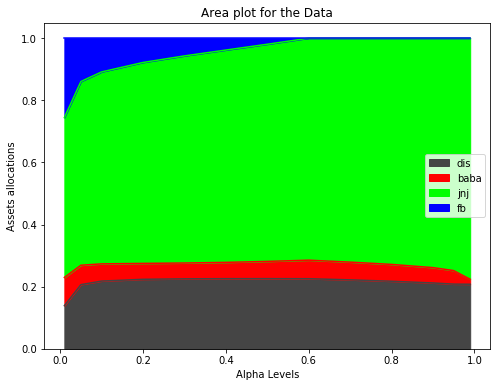

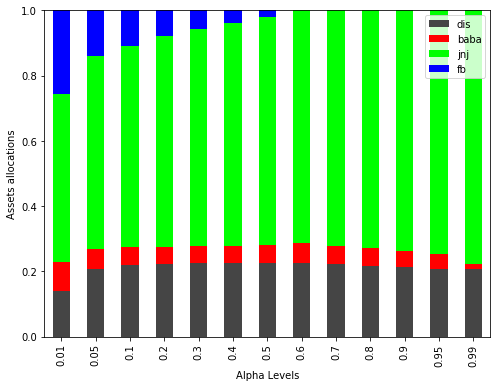

In [22]:
alpha = np.array([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
data = {'dis':dis,'baba':baba,'jnj':jnj,'fb':fb}
dfsol = pd.DataFrame(data,index = alpha)
pl = dfsol.plot(kind='area', stacked=True,color= colors, title='Area plot for the Data',figsize = (8,6))
pl.set_ylabel('Assets allocations')
pl.set_xlabel('Alpha Levels')
plt.show()

pl1 = dfsol.plot(kind="bar",stacked = True, color = colors, figsize=(8,6))
pl1.set_ylabel('Assets allocations')
pl1.set_xlabel('Alpha Levels')
plt.show()

#### Plot for asset allocation with a risk free asset

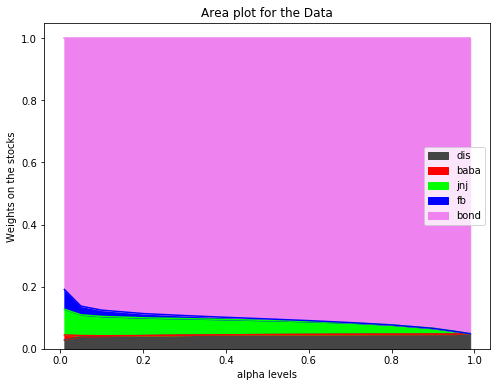

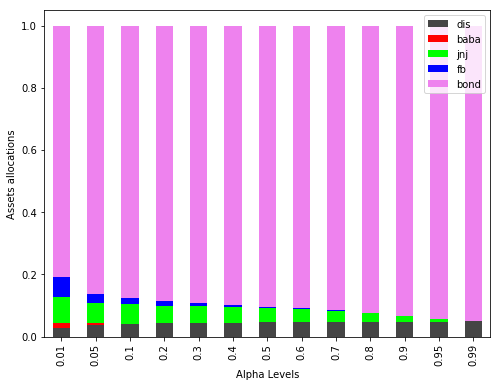

In [16]:
alpha = np.array([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
datafree = {'dis':disfree,'baba':babafree,'jnj':jnjfree,'fb':fbfree,'bond':bond}
dfsolfree = pd.DataFrame(datafree,index = alpha)
pl = dfsolfree.plot(kind='area', stacked=True,color= colorss, title='Area plot for the Data',figsize = (8,6))
pl.set_ylabel('Weights on the stocks')
pl.set_xlabel('alpha levels')
plt.show()

pl1 = dfsolfree.plot(kind="bar",stacked = True, color = colorss, figsize=(8,6))
pl1.set_ylabel('Assets allocations')
pl1.set_xlabel('Alpha Levels')
plt.show()

#### Plot for solution and t values without risk free asset

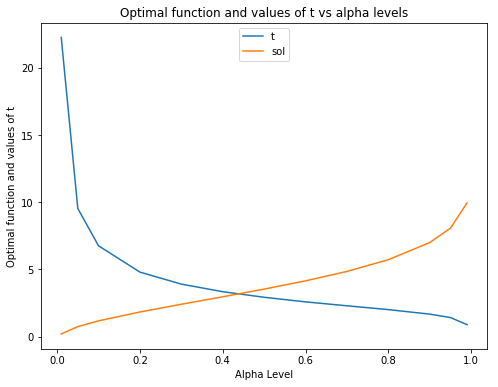

In [18]:
# Optimal solution and t values against alpha values
alpha = np.array([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
data_t_sol = {'t':t_values,'sol':sol}
df_t_sol = pd.DataFrame(data_t_sol,index = alpha)
#plot
pl_t_sol = df_t_sol.plot(kind='line', title='Optimal function and values of t vs alpha levels',figsize = (8,6))
pl_t_sol.set_ylabel('Optimal function and values of t')
pl_t_sol.set_xlabel('Alpha Level')
pl_t_sol.legend(loc = "upper center")
plt.show()